In [82]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, callbacks
import tensorflow.keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

In [171]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [172]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [173]:
import warnings
warnings.filterwarnings("ignore")

In [174]:
image_width = 224
image_height = 224
num_classes = 5
histories = []

In [175]:
images_dir = "flowers-subset/"
train_data_dir = images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"

In [205]:
images_dir = "flowers-subset/"
flowers_complete = "flowers-complete/"
train_data_dir = images_dir + "train/"
val_data_dir = flowers_complete
test_data_dir = flowers_complete #+ "test/"

In [206]:
checkpoint_dir = "checkpoints/"
checkpoint_name = checkpoint_dir + "flora-transferLearning-{val_loss:.4f}-{val_accuracy:.4f}.hdf5"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [207]:
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_accuracy", patience=10, verbose=1),

        callbacks.ModelCheckpoint(checkpoint_name, monitor="val_accuracy", 
                                  verbose=1, save_best_only=True),
    ]

my_callbacks = create_callbacks()

In [208]:
my_callbacks = create_callbacks()

In [209]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(input_shape=(image_height, image_width, 3), 
                       include_top=False, weights="imagenet", 
                       pooling=None)

In [210]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=0.2,
                    horizontal_flip=True,
                    fill_mode="nearest",
                    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [211]:
batch_size = 64

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=True)

val_generator = val_datagen.flow_from_directory(
                    val_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

test_generator = test_datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

Found 25 images belonging to 5 classes.
Found 4323 images belonging to 5 classes.
Found 4323 images belonging to 5 classes.


In [215]:
from tensorflow.keras import regularizers

top_model = Sequential()
top_model.add(base_model)
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.7))
top_model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01)))
top_model.add(Activation("softmax"))

In [213]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), input_shape=(image_height, image_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#b
model.add(Conv2D(32, (1, 1)))
model.add(Activation('relu'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation("softmax"))

In [216]:
for layer in base_model.layers:
    layer.trainable = False

top_model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr=1e-4),
                  metrics=["accuracy"])    

In [217]:
histories.append(top_model.fit(train_generator, 
                              steps_per_epoch=len(train_generator),
                              epochs=60,
                              callbacks=my_callbacks,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              workers=8))

Epoch 1/60
1/1 [==============================] - 7s 7s/step - loss: 3.0654 - accuracy: 0.0800 - val_loss: 2.0516 - val_accuracy: 0.1716

Epoch 00001: val_accuracy improved from -inf to 0.17164, saving model to checkpoints/flora-transferLearning-2.0516-0.1716.hdf5
Epoch 2/60
1/1 [==============================] - 5s 5s/step - loss: 2.5642 - accuracy: 0.2400 - val_loss: 2.0402 - val_accuracy: 0.1735

Epoch 00002: val_accuracy improved from 0.17164 to 0.17349, saving model to checkpoints/flora-transferLearning-2.0402-0.1735.hdf5
Epoch 3/60
1/1 [==============================] - 5s 5s/step - loss: 2.9674 - accuracy: 0.1200 - val_loss: 2.0297 - val_accuracy: 0.1753

Epoch 00003: val_accuracy improved from 0.17349 to 0.17534, saving model to checkpoints/flora-transferLearning-2.0297-0.1753.hdf5
Epoch 4/60
1/1 [==============================] - 5s 5s/step - loss: 2.6490 - accuracy: 0.0400 - val_loss: 2.0190 - val_accuracy: 0.1774

Epoch 00004: val_accuracy improved from 0.17534 to 0.17742, s


Epoch 00031: val_accuracy improved from 0.24705 to 0.25006, saving model to checkpoints/flora-transferLearning-1.7945-0.2501.hdf5
Epoch 32/60
1/1 [==============================] - 5s 5s/step - loss: 2.3869 - accuracy: 0.1600 - val_loss: 1.7877 - val_accuracy: 0.2505

Epoch 00032: val_accuracy improved from 0.25006 to 0.25052, saving model to checkpoints/flora-transferLearning-1.7877-0.2505.hdf5
Epoch 33/60
1/1 [==============================] - 5s 5s/step - loss: 2.0747 - accuracy: 0.4000 - val_loss: 1.7813 - val_accuracy: 0.2528

Epoch 00033: val_accuracy improved from 0.25052 to 0.25283, saving model to checkpoints/flora-transferLearning-1.7813-0.2528.hdf5
Epoch 34/60
1/1 [==============================] - 5s 5s/step - loss: 2.2909 - accuracy: 0.2400 - val_loss: 1.7749 - val_accuracy: 0.2556

Epoch 00034: val_accuracy improved from 0.25283 to 0.25561, saving model to checkpoints/flora-transferLearning-1.7749-0.2556.hdf5
Epoch 35/60
1/1 [==============================] - 5s 5s/step 

## Evaluate on the best model

In [155]:
from tensorflow.keras.models import load_model
model_saved_name = ""

best_model = load_model(checkpoint_dir + "flora-transferLearning-0.3959-0.8959.hdf5")

In [156]:
best_model.evaluate_generator(test_generator, steps=len(test_generator))

[0.3959440588951111, 0.895905613899231]

In [157]:
test_generator.reset()
probabilities = best_model.predict_generator(test_generator, steps=len(test_generator))
predicted_labels = np.argmax(probabilities, axis=-1)

In [158]:
target_labels = test_generator.classes

In [159]:
from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predicted_labels)


In [160]:
import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

In [161]:
labels = [""] * num_classes
for k, v in test_generator.class_indices.items():
    labels[v] = k

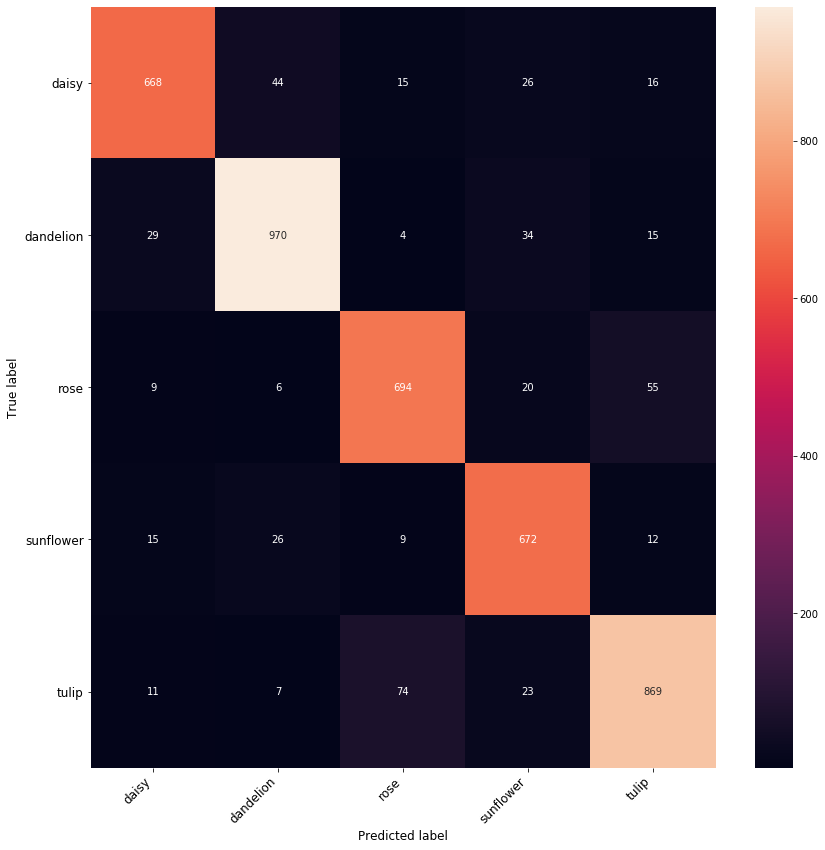

In [162]:
plot_confusion_matrix(conf, labels, figsize=(14, 14))

In [167]:
print(metrics.classification_report(target_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

       daisy       0.91      0.87      0.89       769
   dandelion       0.92      0.92      0.92      1052
        rose       0.87      0.89      0.88       784
   sunflower       0.87      0.92      0.89       734
       tulip       0.90      0.88      0.89       984

    accuracy                           0.90      4323
   macro avg       0.89      0.89      0.89      4323
weighted avg       0.90      0.90      0.90      4323



In [168]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(probabilities, axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {v:k for k,v in test_generator.class_indices.items()}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f\n" % (
        test_generator.filenames[i],
        index2class[predicted_labels[i]],
        probs_max[i]
    ))

dandelion/129019877_8eea2978ca_m.jpg was predicted as 'sunflower' 0.9721

rose/3971662839_5cb2963b20_n.jpg was predicted as 'tulip' 0.9711

rose/14312910041_b747240d56_n.jpg was predicted as 'tulip' 0.9685

tulip/466409031_4c10294db5_m.jpg was predicted as 'rose' 0.9560

tulip/3238068295_b2a7b17f48_n.jpg was predicted as 'rose' 0.9538



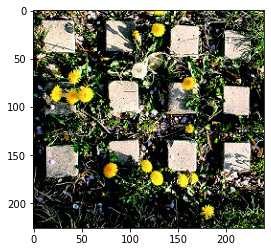

In [169]:
from keras.preprocessing import image
img = image.load_img(test_data_dir + test_generator.filenames[worst_predictions[0]])
plt.imshow(img)

## Export to Core ML

Restart kernel with mlvenv with "source mlvenv/bin/activate" for coremltools part

In [17]:
import coremltools as ct
import os
from tensorflow.keras.models import load_model

In [18]:
label_dir = "ava/"
labels = []
checkpoint_dir = "checkpoints/"
best_model = tensorflow.keras.load_model(checkpoint_dir + "multisnacks-1.6708-0.4054.hdf5")

NameError: name 'tensorflow' is not defined

In [3]:
for i in os.listdir(label_dir):
    if i != '.DS_Store' and i != '._.DS_Store':
        labels.append(i)

In [4]:
coreml_model = ct.convert(
    best_model,
    input_names=["image"],
    image_input_names="image",
    output_names="labelProbability",
    predicted_feature_name="label",
    red_bias=-1,
    green_bias=-1,
    blue_bias=-1,
    image_scale=2/255.0,
    class_labels=labels)

Translating MIL ==> MLModel Ops: 100%|██████████| 701/701 [00:00<00:00, 3765.88 ops/s]


In [5]:
coreml_model.author = "Joshua Ball"
coreml_model.short_description = "Image classifier"

coreml_model.input_description["image"] = "Input image"
coreml_model.output_description["labelProbability"]= "Prediction probabilities"
coreml_model.output_description["label"]= "Class label of top prediction"

AttributeError: No feature with name image.

In [6]:
coreml_model.save("MultiSnacks.mlmodel")

In [7]:
m = ct.models.MLModel("MultiSnacks.mlmodel")

In [8]:
import numpy as np
import PIL.Image


In [9]:
Height = 224  # use the correct input image height
Width = 224  # use the correct input image width

In [10]:
def load_image(path, resize_to=None):
    # resize_to: (Width, Height)
    img = PIL.Image.open(path)
    if resize_to is not None:
        img = img.resize(resize_to, PIL.Image.ANTIALIAS)
    img_np = np.array(img).astype(np.float32)
    return img_np, img


In [13]:
_, img = load_image('ava/Ripe/focused_184465770-stock-photo-whole-ripe-avocado.jpg', resize_to=(Width, Height))
out_dict = m.predict({'image': img})


Exception: Model prediction is only supported on macOS version 10.13 or later.

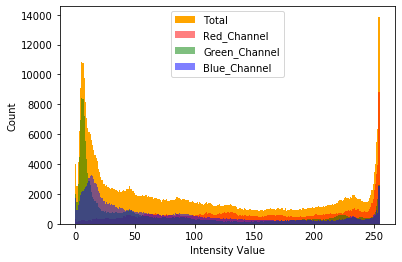

In [218]:
from skimage import io
import matplotlib.pyplot as plt
image = io.imread('a.jpg')

_ = plt.hist(image.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

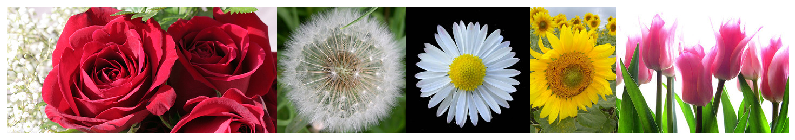

In [328]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(14., 14.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )

image_data = [io.imread('a.jpg'), io.imread('b.jpg'),io.imread('c.jpg'),io.imread('d.jpg'),io.imread('e.jpg')]
for ax, im in zip(grid, image_data):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,interpolation='nearest') 
    ax.set_axis_off()

    plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Tulip')

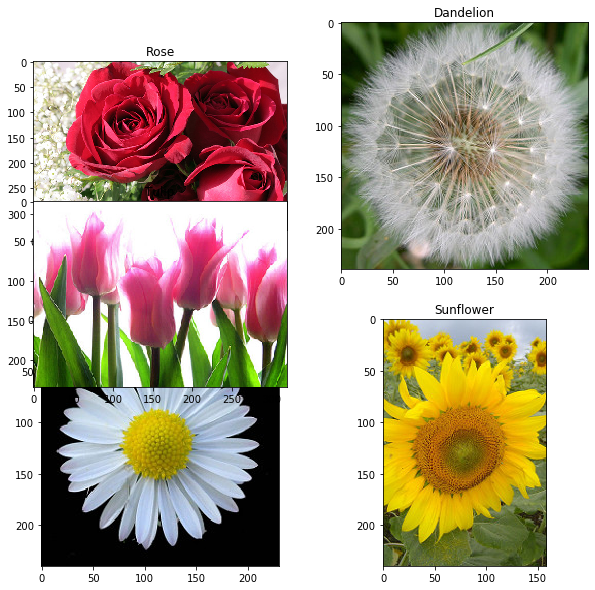

In [277]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(io.imread('a.jpg'))
ax.set_title('Rose')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7],  orientation='horizontal')
imgplot.set_clim(0.0, 0.7)

ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(io.imread('b.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Dandelion')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

ax = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(io.imread('c.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Dandelion')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

ax = fig.add_subplot(2, 2, 4)
imgplot = plt.imshow(io.imread('d.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Sunflower')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(io.imread('e.jpg'))
imgplot.set_clim(0.0, 0.7)
ax.set_title('Tulip')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')